In [1]:

import os
import sys
import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from pathlib import Path

from tqdm import tqdm
from utilsFn import *
import numpy as np

import CDDSM
import time
import logging
import copy
import argparse
import numpy
import progressbar as pb

checkpoint = torch.load('./models/')


batch_size = 1
learning_rate = 0.01

#Image size
img_resize=H=W=512

test_file='temp.csv'
homedir  = str(Path.home())


In [2]:
test_classes=3
test_df,test_classes = CDDSM.createTestFrame(homedir)
test_df.to_csv('temp.csv')
print(test_classes)
num_classes=test_classes

2


In [3]:
################ Pretrained Resnet Model ####################
resnet = models.resnet18(pretrained=True)
features_len = resnet.fc.in_features
resnet = nn.Sequential(*list(resnet.children())[:-1])



# for param in resnet.parameters():
#     param.requires_grad = False
    
    
class myCustomModel(torch.nn.Module):
    def __init__(self,pretrainedModel,features_len,classes):
        super(myCustomModel,self).__init__()
        
        self.layer0 = nn.Sequential()
        self.layer0.add_module('conv0',nn.Conv2d(1,3,kernel_size=9,stride=1,padding=0,dilation=8))
        self.layer0.add_module('relu0',nn.ReLU())
        self.layer0.add_module('maxpool',nn.MaxPool2d(kernel_size=2))
        self.layer1 = nn.Sequential()
        self.layer1.add_module('pretrained',pretrainedModel)
        self.fc = nn.Linear(in_features=features_len,out_features=classes)
    def forward(self,x):
        x = self.layer0(x)
        features = self.layer1(x)
        features = features.view(features.size(0), -1)
        x =  self.fc(features)
        return features , x

def getCustomPretrained(model,features_len,classes):
    return myCustomModel(model,features_len,classes)
    
    
# parameters with parameters requires grad is True
# for p in resnet18.parameters():
#     print(p.requires_grad)

# model = B.getModel(3).to(device)


# In[72]:


# model = B.getModel(3).to(device)
model=getCustomPretrained(resnet,features_len,num_classes)


In [4]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

11177784


In [5]:

test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1, 
                                          shuffle=False)


number_of_testing_data = test_dataset.__len__()


total_step = len(test_loader)
print(number_of_testing_data)
widgets = ['Progress for train data cleaning: ', pb.Percentage(), ' ', 
            pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]


600


In [ ]:
# dataiter = iter(test_loader)
# img,labels,path = dataiter.next()

In [6]:
model.load_state_dict(checkpoint['state_dict'])

In [11]:
true = []
predicted = []
prob = []
model = model.eval()
timer = pb.ProgressBar(widgets=widgets, maxval=total_step+1).start()
with torch.no_grad():
    for i,(img,label,path) in enumerate(test_loader):
        timer.update(i)
        
        _,out = model(img)
        
        pred = F.softmax(out,1).squeeze(0).numpy()
        
        predlabel = numpy.argmax(pred)
        
        #print(predlabel)
        #print(out.squeeze(0).numpy())
        #print(label.numpy().item())
        
        true.append(label.numpy().item())
        predicted.append(predlabel)
        prob.append(pred)
timer.finish()   

Progress for train data cleaning: 100% |||||||||||||||||||||||||| Time: 0:14:20


In [13]:
probN = np.asarray(prob)
probN

array([[0.5046619 , 0.49533814],
       [0.5112984 , 0.48870158],
       [0.5277702 , 0.4722298 ],
       ...,
       [0.48561627, 0.5143838 ],
       [0.4282798 , 0.57172024],
       [0.54685116, 0.4531488 ]], dtype=float32)

In [ ]:
len(probN)


In [9]:
def imshow(img,title='None'):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
#     npimg = npimg.squeeze(2)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(2),cmap='gray')

1


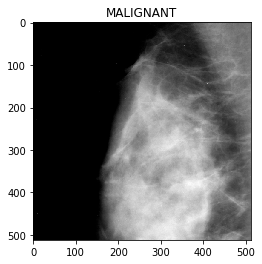

In [10]:
img,label,labelstr = test_dataset[10]
imshow(img,labelstr)
print(label)

/home/himanshu/py3Env/lib/python3.5/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


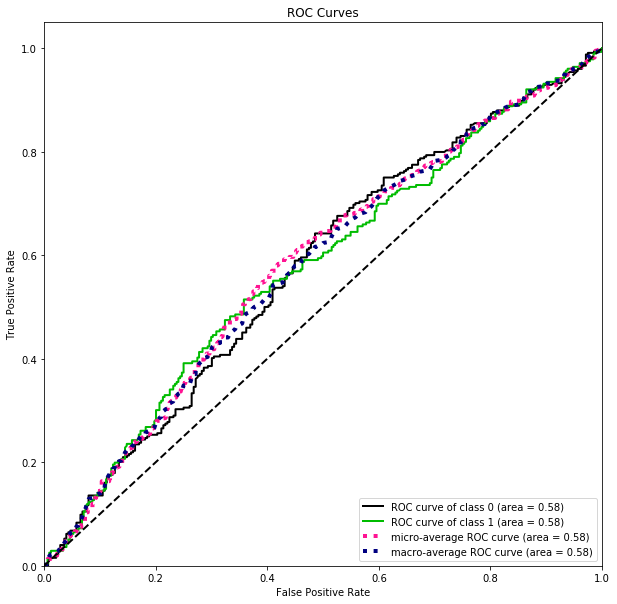

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# y_true = # ground truth labels
# y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(true, probN)
plt.rcParams['figure.figsize']=[10,10]
plt.show()

In [16]:
correctindex=[]
wrongindex =[]
for i in range(len(true)):
    
    if(true[i]==predicted[i]):
        correctindex.append(i)
    else:
        wrongindex.append(i)
    


In [17]:
data = {}
data['true'] = true
data['pred'] = predicted
data['prob'] = probN
data['correct'] = correctindex
data['wrong'] = wrongindex
import numpy as np

# Save

np.save('./models/26Nov20180617/results3.npy', data) 

# Load
read_dictionary = np.load('./models/26Nov20180617/results3.npy').item()
print(read_dictionary['prob']) # displays "world"

[[0.5046619  0.49533814]
 [0.5112984  0.48870158]
 [0.5277702  0.4722298 ]
 ...
 [0.48561627 0.5143838 ]
 [0.4282798  0.57172024]
 [0.54685116 0.4531488 ]]


In [ ]:
print